# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.dbscan import dbscan
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

from t1_constants import *
from t1_utility import *
from itertools import product

In [53]:
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{BASKET_DF}.pkl', 'rb') as f:
    pure_b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{ITEM_DF}.pkl', 'rb') as f:
    pure_i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{USER_DF}.pkl', 'rb') as f:
    pure_u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{SHOP_DF}.pkl', 'rb') as f:
    pure_s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{TOTAL_DF}.pkl', 'rb') as f:
    pure_total_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PURE}{PREPARED}{DATE_DF}.pkl', 'rb') as f:
    pure_d_df = pickle.load(f)

In [54]:
with open(f'{PICKLE_FOLDER}{PREPARED}{BASKET_DF}.pkl', 'rb') as f:
    b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PREPARED}{ITEM_DF}.pkl', 'rb') as f:
    i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PREPARED}{USER_DF}.pkl', 'rb') as f:
    u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PREPARED}{SHOP_DF}.pkl', 'rb') as f:
    s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PREPARED}{TOTAL_DF}.pkl', 'rb') as f:
    total_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}{PREPARED}{DATE_DF}.pkl', 'rb') as f:
    d_df = pickle.load(f)

## Outliers

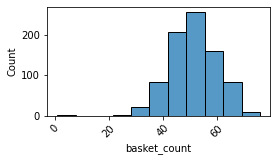

In [55]:
loghist(u_df, BCNT, '')

In [56]:
u_df[u_df[BCNT] < 20].index

Int64Index([824], dtype='int64', name='user_id')

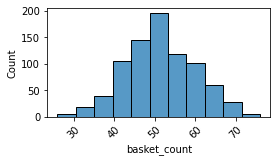

In [57]:
loghist(u_df.drop(u_df[u_df[BCNT] < 20].index), BCNT, '')

In [58]:
u_df = u_df.drop(u_df[u_df[BCNT] < 20].index)

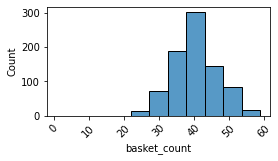

In [59]:
loghist(pure_u_df, BCNT, '')

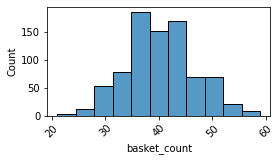

In [60]:
loghist(pure_u_df.drop(pure_u_df[pure_u_df[BCNT] < 20].index), BCNT, '')

In [61]:
pure_u_df = pure_u_df.drop(pure_u_df[pure_u_df[BCNT] < 20].index)

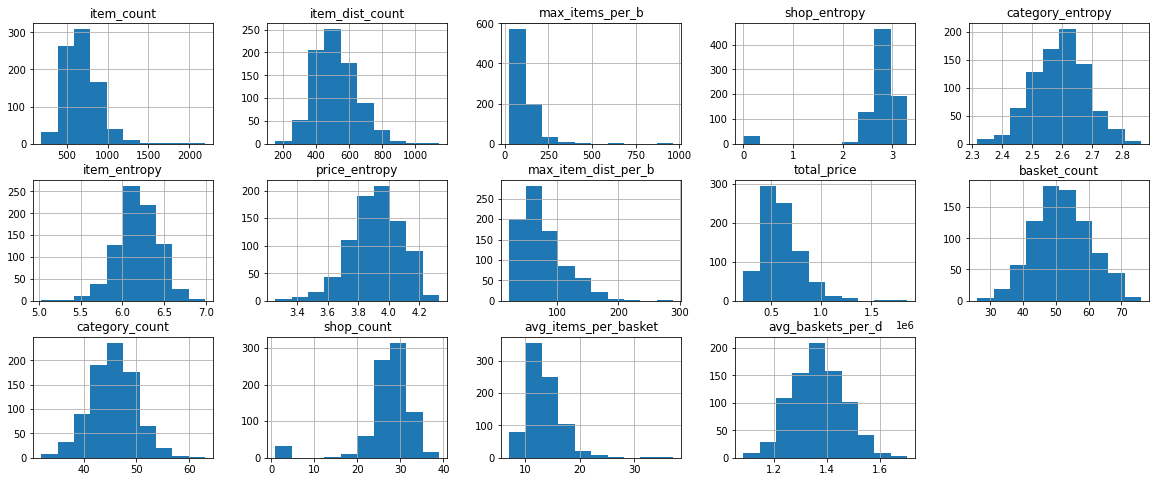

In [62]:
u_df.hist(layout= (3, 5), figsize = (20, 8), bins = int(np.log2(len(u_df)) + 1))
plt.show()

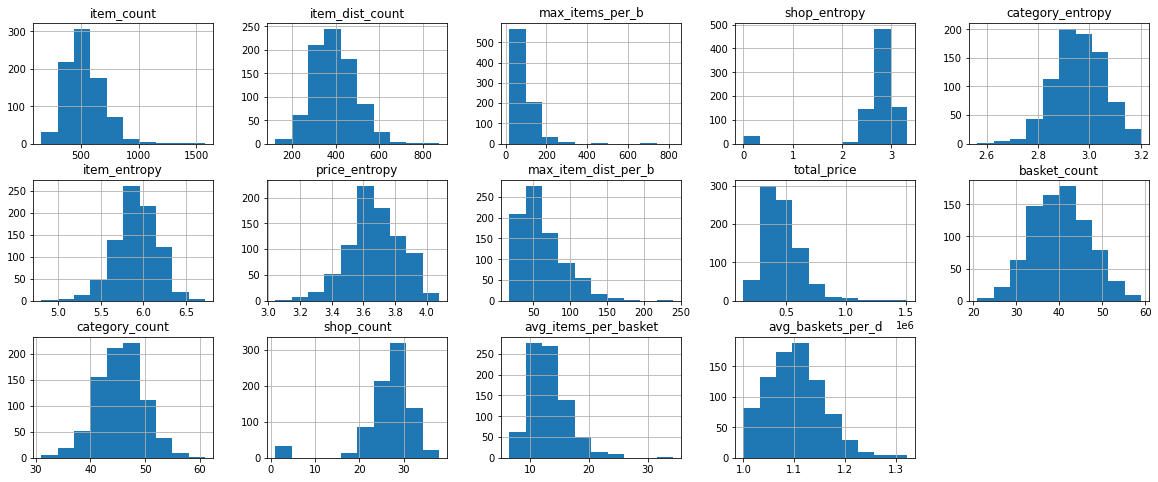

In [63]:
pure_u_df.hist(layout= (3, 5), figsize = (20, 8), bins = int(np.log2(len(pure_u_df)) + 1))
plt.show()

## DBSCAN

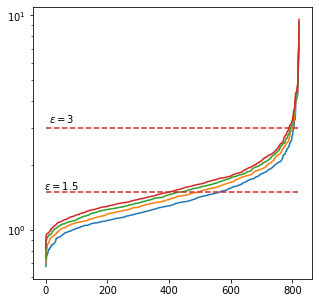

In [28]:
interesting = [823, 103, 313, 412, 162]
data = StandardScaler().fit_transform(u_df)
dist = squareform(pdist(data, 'euclidean'))
EMIN = 1.5
EMAX = 3
KMIN = 2
KMAX = 6
eps_range = [x / 10 for x in range(int(EMIN * 10), int(EMAX * 10))]
k_range = [x for x in range(KMIN, KMAX)]

plt.figure(figsize=(5, 5))
for k in k_range:
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances), label=f'k = {k}')
plt.hlines([EMIN, EMAX], xmin=0, xmax=data.shape[0], colors='tab:red', linestyles='--')
plt.text(50, EMIN+0.1, f'$\epsilon={EMIN}$', fontsize=10, va='center', ha='center')
plt.text(50, EMAX+0.3, f'$\epsilon={EMAX}$', fontsize=10, va='center', ha='center')

plt.yscale('log')
plt.show()

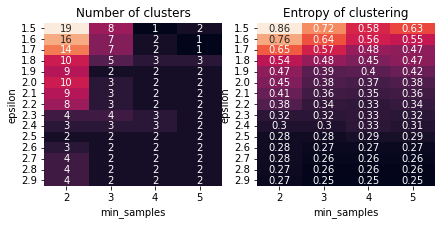

In [29]:
def entropy(v):
    relative_f = v.value_counts().values / len(v)
    return - np.sum(relative_f * np.log(relative_f))

def dbscan_evaluate(points, epsilon, k):
    dbscan_ins = DBSCAN(eps=epsilon, min_samples=k)
    dbscan_ins.fit(points)
    non_outlier_mask = dbscan_ins.labels_ >= 0
    n_clusters = len(np.unique(dbscan_ins.labels_[non_outlier_mask]))
    return n_clusters, entropy(pd.Series(dbscan_ins.labels_))

results_clusters = pd.DataFrame()
results_entropy = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    n_clusters, _entropy = dbscan_evaluate(data, epsilon, k)
    results_clusters.loc[epsilon, k] = n_clusters
    results_entropy.loc[epsilon, k] = _entropy

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes = axes.ravel()
sns.heatmap(results_clusters, annot = True, ax=axes[0], cbar = False).set_title("Number of clusters")
axes[0].tick_params(labelrotation=0)
sns.heatmap(results_entropy, annot=True, ax=axes[1], cbar=False).set_title("Entropy of clustering")
axes[1].tick_params(labelrotation=0)

for ax in axes:
    ax.set_xlabel("min_samples")
    ax.set_ylabel("epsilon")
plt.show()

In [30]:
results_noise = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    dbscan_ins = dbscan(data, epsilon, k)
    dbscan_ins.process()
    noise = dbscan_ins.get_noise()
    results_noise.loc[epsilon, k] = len(noise)

In [31]:
results_noise

,2,3,4,5
1.5,187.0,219.0,235.0,247.0
1.6,155.0,178.0,196.0,204.0
1.7,119.0,138.0,148.0,162.0
1.8,91.0,102.0,110.0,126.0
1.9,73.0,76.0,84.0,90.0
2.0,55.0,59.0,66.0,74.0
2.1,46.0,52.0,55.0,56.0
2.2,40.0,46.0,49.0,50.0
2.3,27.0,36.0,41.0,43.0
2.4,25.0,30.0,35.0,38.0


In [32]:
dbscan_ins = dbscan(data, 2.2, 2)
dbscan_ins.process()
noise = dbscan_ins.get_noise()
noise

[10,
 137,
 168,
 190,
 191,
 202,
 207,
 222,
 226,
 243,
 254,
 283,
 307,
 336,
 337,
 403,
 405,
 412,
 481,
 503,
 509,
 523,
 530,
 548,
 551,
 558,
 564,
 570,
 583,
 611,
 643,
 644,
 673,
 696,
 698,
 707,
 728,
 736,
 739,
 779]

In [33]:
u_df = u_df.drop(noise)


In [34]:
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 1 to 823
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_count            783 non-null    int64  
 1   item_dist_count       783 non-null    int64  
 2   max_items_per_b       783 non-null    int64  
 3   shop_entropy          783 non-null    float64
 4   category_entropy      783 non-null    float64
 5   item_entropy          783 non-null    float64
 6   price_entropy         783 non-null    float64
 7   max_item_dist_per_b   783 non-null    int64  
 8   total_price           783 non-null    float64
 9   basket_count          783 non-null    int64  
 10  category_count        783 non-null    int64  
 11  shop_count            783 non-null    int64  
 12  avg_items_per_basket  783 non-null    float64
 13  avg_baskets_per_d     783 non-null    float64
dtypes: float64(7), int64(7)
memory usage: 91.8 KB


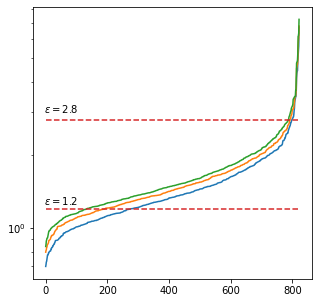

In [35]:
pure_data = StandardScaler().fit_transform(pure_u_df)
dist = squareform(pdist(pure_data, 'euclidean'))
EMIN = 1.2
EMAX = 2.8
KMIN = 2
KMAX = 5
eps_range = [x / 10 for x in range(int(EMIN * 10), int(EMAX * 10))]
k_range = [x for x in range(KMIN, KMAX)]

plt.figure(figsize=(5, 5))
for k in k_range:
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances), label=f'k = {k}')
plt.hlines([EMIN, EMAX], xmin=0, xmax=data.shape[0], colors='tab:red', linestyles='--')
plt.text(50, EMIN+0.1, f'$\epsilon={EMIN}$', fontsize=10, va='center', ha='center')
plt.text(50, EMAX+0.3, f'$\epsilon={EMAX}$', fontsize=10, va='center', ha='center')

plt.yscale('log')
plt.show()

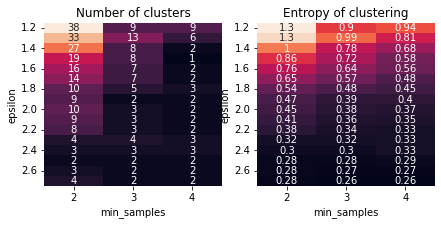

In [36]:
def entropy(v):
    relative_f = v.value_counts().values / len(v)
    return - np.sum(relative_f * np.log(relative_f))

def dbscan_evaluate(points, epsilon, k):
    dbscan_ins = DBSCAN(eps=epsilon, min_samples=k)
    dbscan_ins.fit(points)
    non_outlier_mask = dbscan_ins.labels_ >= 0
    n_clusters = len(np.unique(dbscan_ins.labels_[non_outlier_mask]))
    return n_clusters, entropy(pd.Series(dbscan_ins.labels_))

results_clusters = pd.DataFrame()
results_entropy = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    n_clusters, _entropy = dbscan_evaluate(data, epsilon, k)
    results_clusters.loc[epsilon, k] = n_clusters
    results_entropy.loc[epsilon, k] = _entropy

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes = axes.ravel()
sns.heatmap(results_clusters, annot = True, ax=axes[0], cbar = False).set_title("Number of clusters")
axes[0].tick_params(labelrotation=0)
sns.heatmap(results_entropy, annot=True, ax=axes[1], cbar=False).set_title("Entropy of clustering")
axes[1].tick_params(labelrotation=0)

for ax in axes:
    ax.set_xlabel("min_samples")
    ax.set_ylabel("epsilon")
plt.show()

In [37]:
results_noise = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    dbscan_ins = dbscan(pure_data, epsilon, k)
    dbscan_ins.process()
    noise = dbscan_ins.get_noise()
    results_noise.loc[epsilon, k] = len(noise)

In [38]:
results_noise

,2,3,4
1.2,466.0,526.0,557.0
1.3,360.0,407.0,438.0
1.4,275.0,311.0,342.0
1.5,224.0,253.0,269.0
1.6,179.0,202.0,218.0
1.7,135.0,146.0,174.0
1.8,103.0,111.0,137.0
1.9,83.0,91.0,98.0
2.0,70.0,83.0,87.0
2.1,49.0,64.0,73.0


In [65]:
dbscan_ins = dbscan(data, 2.2, 2)
dbscan_ins.process()
noise = dbscan_ins.get_noise()
noise

[10,
 137,
 168,
 190,
 191,
 202,
 207,
 222,
 226,
 243,
 254,
 283,
 307,
 336,
 337,
 403,
 405,
 412,
 481,
 503,
 509,
 523,
 530,
 548,
 551,
 558,
 564,
 570,
 583,
 611,
 643,
 644,
 673,
 696,
 698,
 707,
 728,
 736,
 739,
 779]

In [66]:
pure_u_df = pure_u_df.drop(noise)

In [67]:
pure_u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 1 to 823
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_count            783 non-null    int64  
 1   item_dist_count       783 non-null    int64  
 2   max_items_per_b       783 non-null    int64  
 3   shop_entropy          783 non-null    float64
 4   category_entropy      783 non-null    float64
 5   item_entropy          783 non-null    float64
 6   price_entropy         783 non-null    float64
 7   max_item_dist_per_b   783 non-null    int64  
 8   total_price           783 non-null    float64
 9   basket_count          783 non-null    int64  
 10  category_count        783 non-null    int64  
 11  shop_count            783 non-null    int64  
 12  avg_items_per_basket  783 non-null    float64
 13  avg_baskets_per_d     783 non-null    float64
dtypes: float64(7), int64(7)
memory usage: 91.8 KB


## Shop rankings and feature selection

In [68]:
def ranking(user_df, shop_df, t_df, figsize=(15,7)):
    # new shop rankings
    shop_df[NAPR] = rankings(shop_df[PAVG], 0).astype('int64')
    shop_df[NABR] = rankings(shop_df[BCNT], 0).astype('int64')
    shop_df[NAIR] = rankings(shop_df[ICNT], 0).astype('int64')

    # new user rankings
    user_df[[NABR, NAIR, NAPR]] = t_df.merge(shop_df[[NABR, NAIR, NAPR]], on=SHOP, how='left').groupby(USER)[[NABR, NAIR, NAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[NABR, NAIR, NAPR]], figsize=figsize)
    plt.show()

    # user_df[[FABR, FAIR, FAPR]] = total_df.merge(shop_df[[FABR, FAIR, FAPR]], on=SHOP, how='left').groupby(USER)[[FABR, FAIR, FAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[FABR, FAIR, FAPR]], figsize=figsize)
    plt.show()
    # scatter matrix with all variables
    pd.plotting.scatter_matrix(user_df, figsize=figsize)

    # pairwise correlation matrix among new variables
    _, axes = plt.subplots(1, 1, figsize=figsize)
    corr_new_matrix = user_df[[NABR, NAIR, NAPR]].corr()
    sns.heatmap(corr_new_matrix, annot=True, cmap="YlGnBu", ax=axes)
    plt.xticks(rotation=60)
    plt.show()


def elimination(user_df, corr_threshold=0.85):
    # elimination of redundant features
    corr_matrix = user_df.corr()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= corr_threshold)]
    print(f"Removed features: {to_drop}")
    func_df = user_df.drop(user_df[to_drop], axis=1)
    return func_df

In [69]:
entropies = [CE,SE,IE]
u_df = u_df.drop(columns=entropies, axis=1)
pure_u_df = pure_u_df.drop(columns=entropies, axis=1)

In [70]:
clustering_df = elimination(u_df, corr_threshold=0.75)

Removed features: ['item_dist_count', 'total_price', 'basket_count', 'avg_items_per_basket']


In [71]:
pure_clustering_df = elimination(pure_u_df, corr_threshold=0.75)

Removed features: ['item_dist_count', 'total_price', 'basket_count', 'avg_items_per_basket']


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'item_count'),
  Text(1.5, 0, 'max_items_per_b'),
  Text(2.5, 0, 'price_entropy'),
  Text(3.5, 0, 'max_item_dist_per_b'),
  Text(4.5, 0, 'category_count'),
  Text(5.5, 0, 'shop_count'),
  Text(6.5, 0, 'avg_baskets_per_d')])

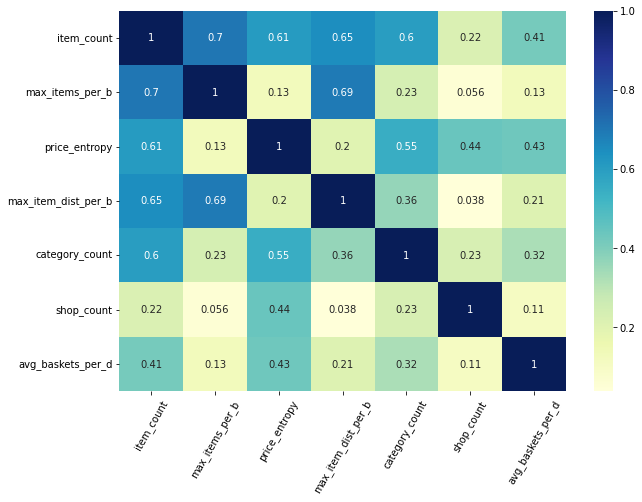

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.heatmap(clustering_df.corr(), annot=True, cmap="YlGnBu", ax=axes)
plt.xticks(rotation=60)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'item_count'),
  Text(1.5, 0, 'max_items_per_b'),
  Text(2.5, 0, 'price_entropy'),
  Text(3.5, 0, 'max_item_dist_per_b'),
  Text(4.5, 0, 'category_count'),
  Text(5.5, 0, 'shop_count'),
  Text(6.5, 0, 'avg_baskets_per_d')])

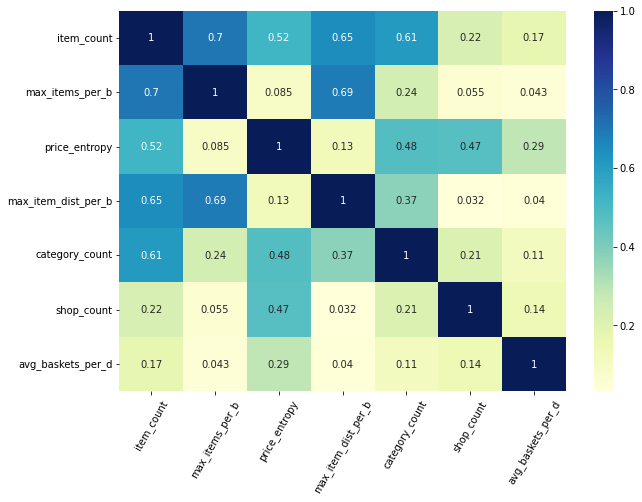

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(10,7))
sns.heatmap(pure_clustering_df.corr(), annot=True, cmap="YlGnBu", ax=axes)
plt.xticks(rotation=60)

## Save datasets

In [74]:
with open(f'{PICKLE_FOLDER}{CLUST_DF}.pkl', 'wb') as f:
    pickle.dump(clustering_df, f)

with open(f'{PICKLE_FOLDER}{PURE}{CLUST_DF}.pkl', 'wb') as f:
    pickle.dump(pure_clustering_df, f)

with open(f'{PICKLE_FOLDER}{SELECTED}{USER_DF}.pkl', 'wb') as f:
    pickle.dump(u_df, f)

with open(f'{PICKLE_FOLDER}{PURE}{SELECTED}{USER_DF}.pkl', 'wb') as f:
    pickle.dump(pure_u_df, f)